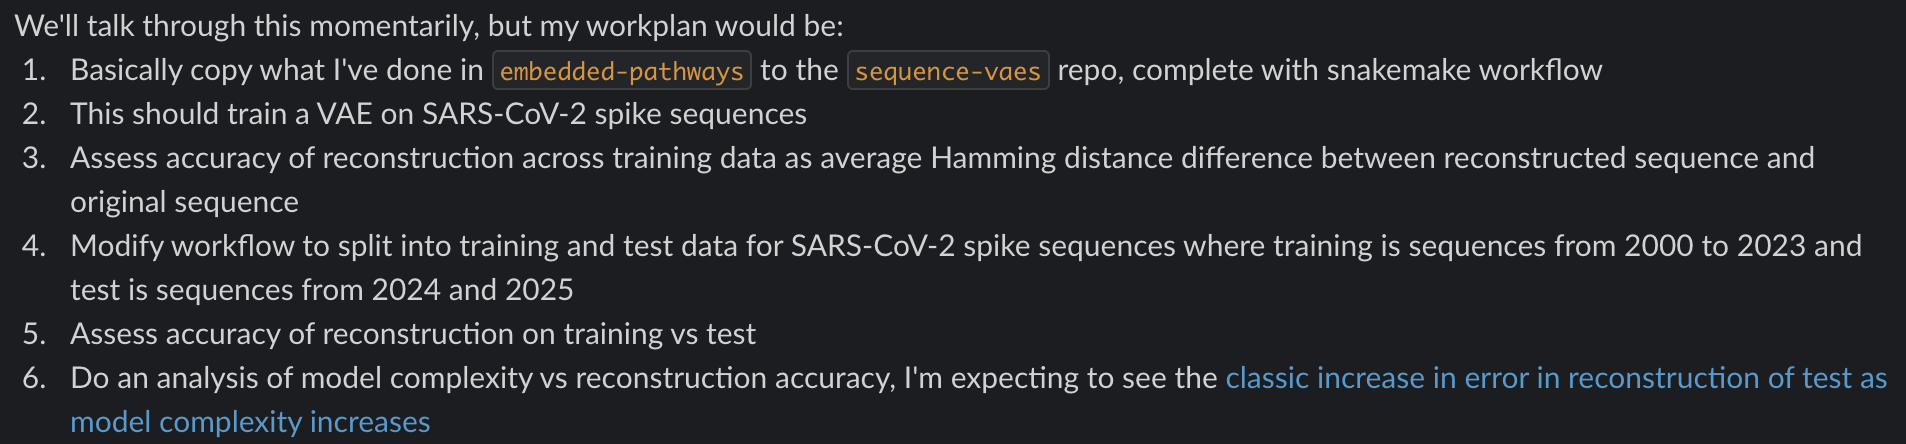

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [4]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford

In [5]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## loss figures

In [7]:
train_logs = []
valid_logs = []

abspath = "./results"
# abspath = "./bedford_code/results_bedford"

N=1
with open(f"{abspath}/train_logs.json", "r") as f:
    train_logs = json.load(f)[N:]

with open(f"{abspath}/valid_logs.json","r") as f:
    valid_logs = json.load(f)[N:]

loss_X = list(range(N,len(valid_logs)+N, 1))

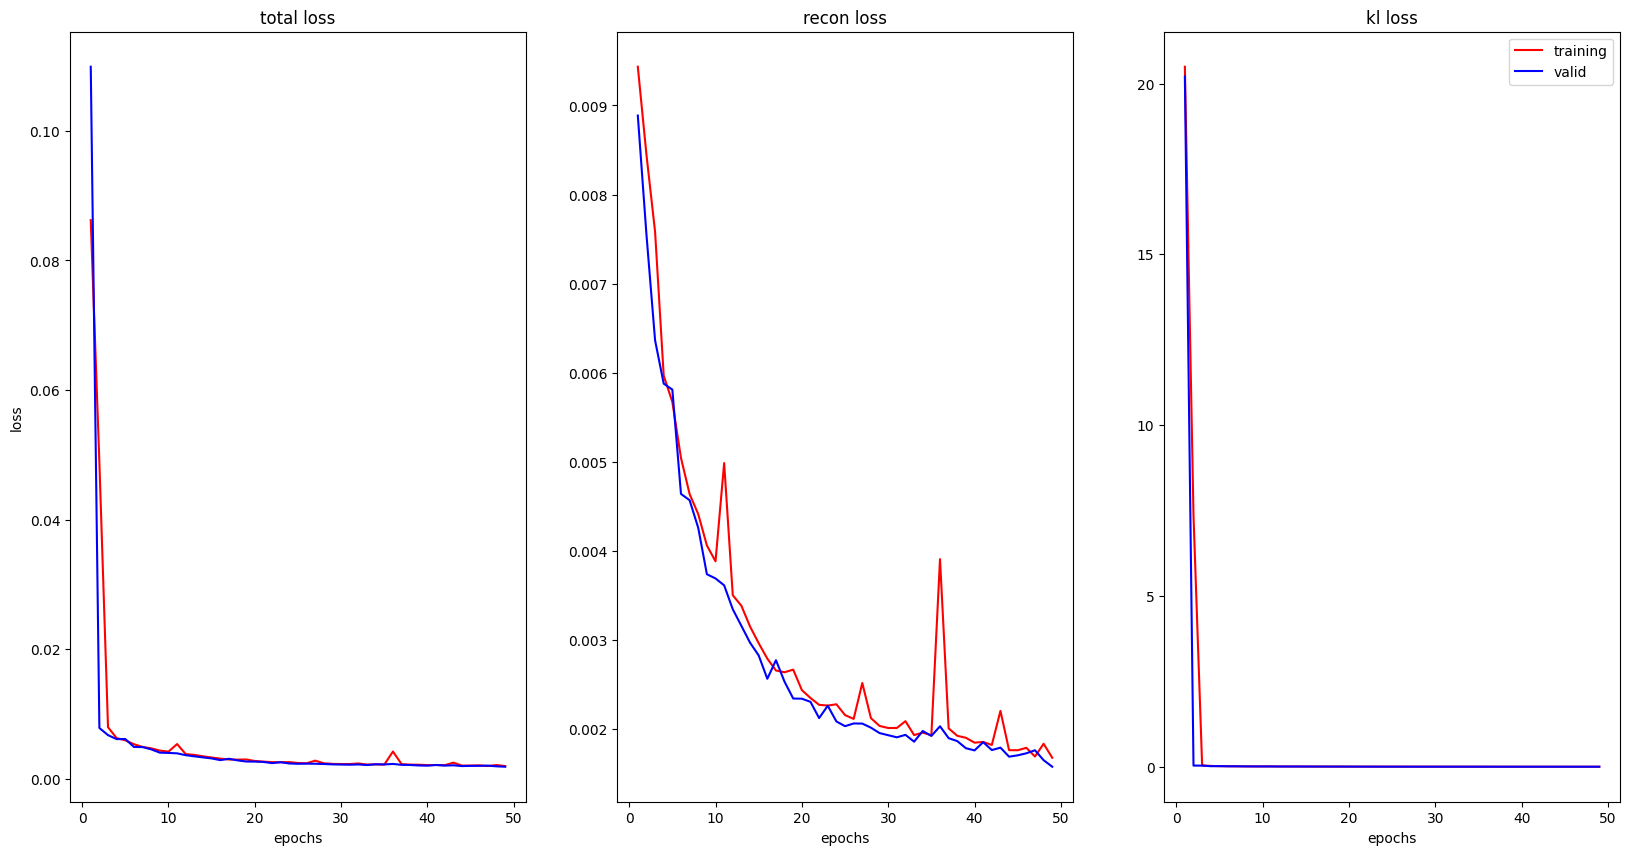

In [8]:
labels = ["total", "recon", "kl"]
colors = ["red", "blue"]

fig,arr = plt.subplots(1,3,figsize=(20,10))

N = len(train_logs)
for i in range(3):
    arr[i].plot(loss_X, [x[i] for x in train_logs], color=colors[0], label="training")
    arr[i].plot(loss_X, [x[i] for x in valid_logs], color=colors[1], label="valid")
    arr[i].set_title("%s loss"%labels[i])
    arr[i].set_xlabel("epochs")
    if i == 0:
        arr[i].set_ylabel("loss")

plt.legend()
fig.show()

## Embedding space Visualizations

In [9]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load("./bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [10]:
dset = ["training", "valid", "test"]
dset = dset[0]
abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]

In [11]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'22A (BA.4)', '21L (BA.2)', '22F (XBB)', '24F (XEC)', '24H (LF.7)', '23I (BA.2.86)', '24I (MV.1)', '25C (XFG)', '25B (NB.1.8.1)', '24D (XDV.1)', '23F (EG.5.1)', '23A (XBB.1.5)', '23D (XBB.1.9)', '19A', '21K (BA.1)', '22D (BA.2.75)', '22C (BA.2.12.1)', '25A (LP.8.1)', '24E (KP.3.1.1)', '24A (JN.1)', '23B (XBB.1.16)', '22B (BA.5)'}


In [12]:
# print(set(clade_labels))

# clusters = np.sort(np.array(list(set(good_clade_labels))))
clusters = np.sort(np.array(list(set(clade_labels))))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']


In [13]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [14]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

In [15]:
# is geodesic working
# implementation of other method

X shape
(6368, 3822, 5)
torch.Size([6368, 3822, 5])

Recon shape
torch.Size([6368, 19110])
[0.45191512 0.3315957  0.19805562]
total variance: 0.9815664291381836


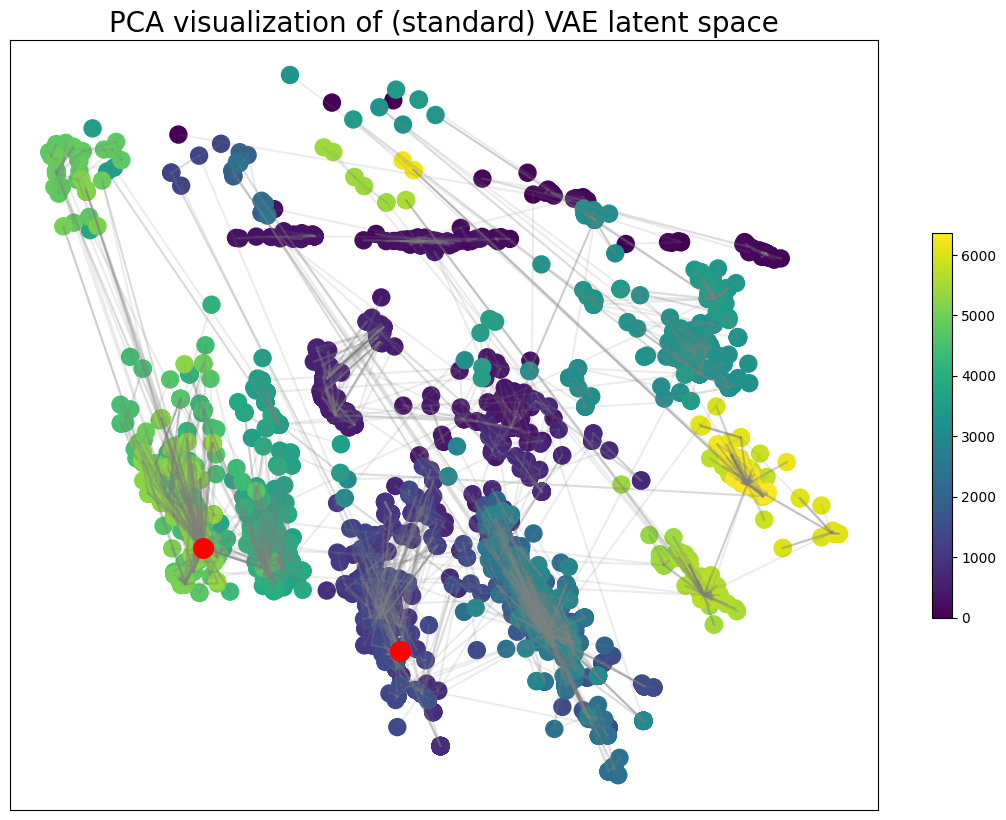

In [32]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=3, svd_solver="full")


recon = None
Z_mean = None
Z_embedded = None
scatterplot = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu().numpy()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()
    
    print("\nRecon shape")
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean - np.mean(Z_mean))
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    

# %matplotlib widget
# plt.ion()
# fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
fig,ax = plt.subplots(1,1,figsize=(14,10))

# # RELATIONS
# for i,arr in enumerate(indexes):
#     # ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 0
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

## GEODESIC
G1 = 1000
G2 = 5000
ax.scatter(Z_embedded[[G1,G2],0], Z_embedded[[G1,G2],1], color="red", s=200,zorder=10)
##

# TIME 
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=collection_dates, cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
fig.colorbar(scatterplot, ax=ax, shrink=0.5)

ax.set_title("PCA visualization of (standard) VAE latent space",fontsize=20)
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.15)
    # ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()


## Riemannian metric

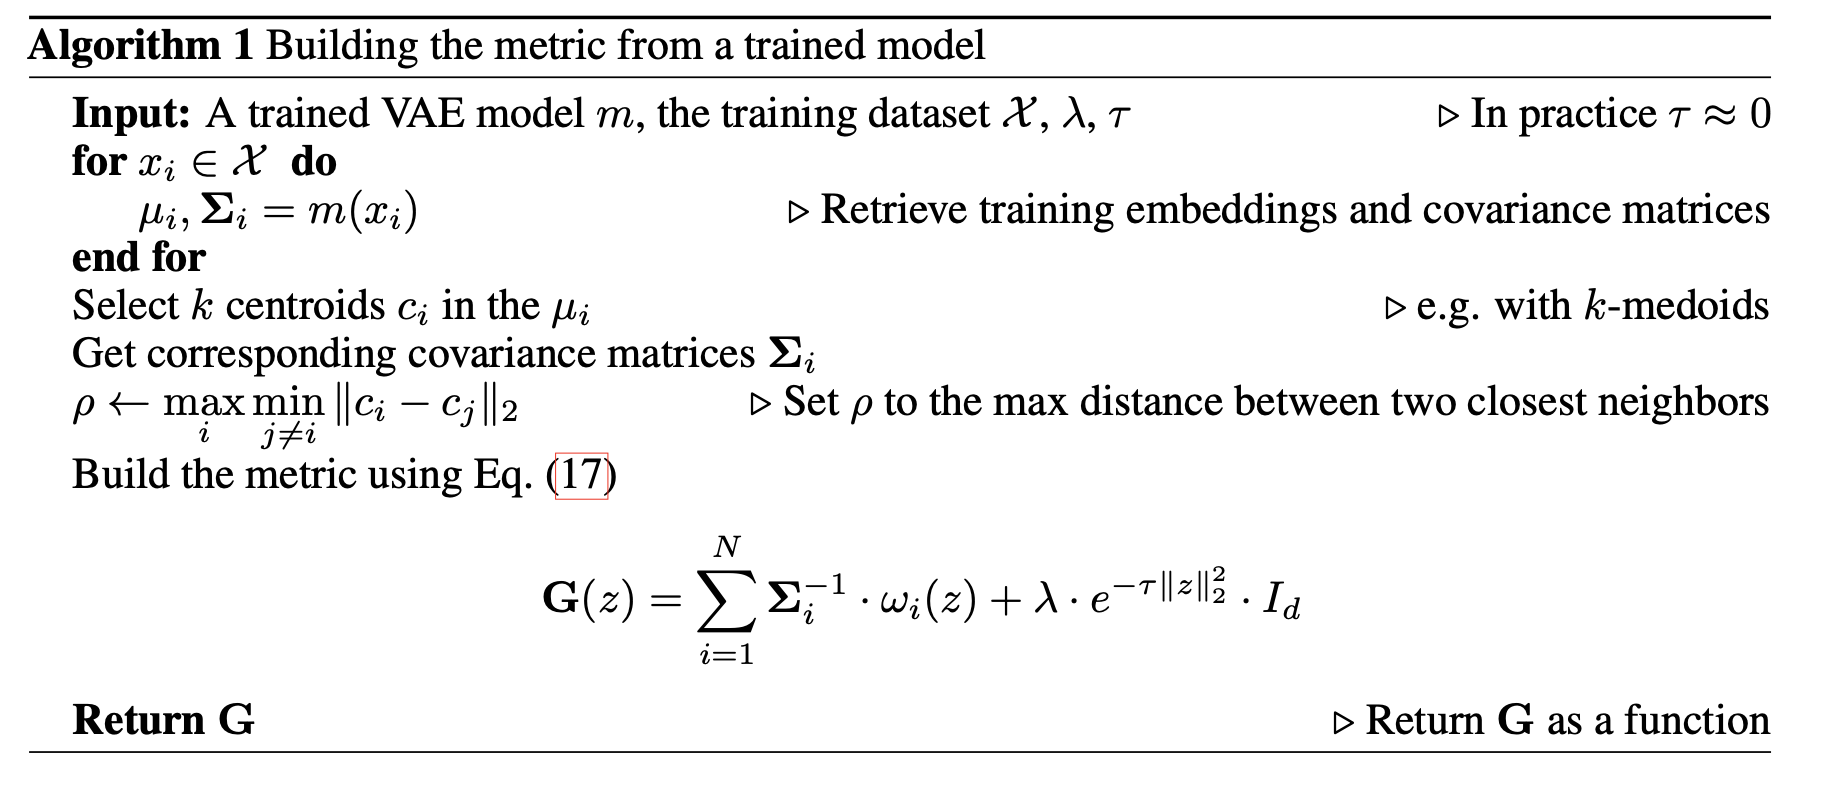

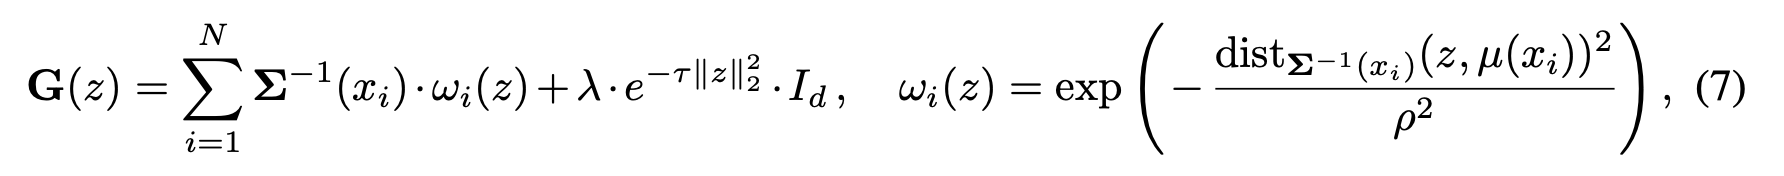

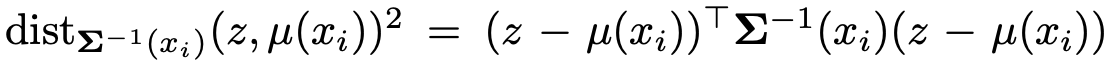

In [18]:
from sklearn_extra.cluster import KMedoids
from scipy.optimize import minimize
from scipy.optimize._numdiff import approx_derivative

In [19]:
def compute_rho(mu, eps=1e-12):
    """rho = max_i min_{j!=i} ||mu_i - mu_j||_2, vectorized."""
    diff = mu[:, None, :] - mu[None, :, :]  # (C,C,D)
    d = np.sum(diff * diff, axis=-1)       # (C,C)
    np.fill_diagonal(d, np.inf)
    rho = np.sqrt(np.max(np.min(d, axis=1) + eps))
    return rho

def dist_func(z, mu, sigma_inv): 
    diff = z[:, None, :] - mu[None, :, :] # (b, 1, dim) - (1, c, dim) = (b, c, dim)
    dist_sq = np.square(np.sum(diff * sigma_inv[None, :, :] * diff, axis=-1)) # (b, c, dim) * (1, c, dim) * (b, c, dim)
    return dist_sq

def omega(z, mu, sigma_inv, rho):
    dists_sq = dist_func(z, mu, sigma_inv)
    return np.exp(-dists_sq / np.square(rho))


def G_batched(z, mu, sigma_var, rho, lam, tau=0, eps=1e-12):
    sigma_inv = 1.0 / (sigma_var + eps) 
    omegas = omega(z, mu, sigma_inv, rho) # (b,c)
    summand = np.dot(omegas, sigma_inv) # (b,dim)
    summand = summand + lam * np.exp(-1.0 * tau * np.sum(np.square(z), axis=-1))[:,None]
    return summand


def _curve_weights(k):
    w = np.full(k, 1.0 / (k - 1))
    w[0] *= 0.5; w[-1] *= 0.5
    return w

def minimize_curve(z0, z1, mu, sigma_var, rho,
                   k=101, lam=0.0, tau=0.0,
                   smooth=0.0, seed=None, method='L-BFGS-B', options=None, eps=1e-12, jac=None):
    """
    Minimize sum_i w_i * [1 / det G(z_i)] with fixed endpoints.
    - z0, z1: (D,)
    - mu: (C,D)
    - sigma_var: (C,D) diagonal variances of Σ_c
    - rho: float
    - k: number of discretization points (len(t)=k)
    - smooth: weight on sum ||Z[i+1]-Z[i]||^2 (optional)
    Returns (Z_opt, scipy_result)
    """
    rng = np.random.default_rng(seed)
    D = z0.shape[0]
    t = np.linspace(0.0, 1.0, k)[:, None]
    Z0 = (1 - t) * z0[None, :] + t * z1[None, :]
    if k > 2:
        Z0[1:-1] += 1e-4 * rng.standard_normal((k-2, D))  # tiny jitter

    w = _curve_weights(k)

    def pack(Z):  # (k,D) -> ((k-2)*D,)
        return Z[1:-1].ravel()

    def unpack(x):  # ((k-2)*D,) -> (k,D) with fixed endpoints
        Z = np.empty((k, D), dtype=float)
        Z[0] = z0
        Z[-1] = z1
        if k > 2:
            Z[1:-1] = x.reshape(k-2, D)
        return Z

    def objective(x):
        Z = unpack(x)
        Gd = G_batched(Z, mu, sigma_var, rho, lam=lam, tau=tau, eps=eps)   # (k,D)
        # 1 / det(G) computed stably: exp(-sum_d log Gd)
        inv_det = np.exp(-np.sum(np.log(Gd + eps), axis=1))        # (k,)
        val = np.sum(w * inv_det)
        if smooth > 0.0:
            diffs = Z[1:] - Z[:-1]
            val += smooth * np.sum(diffs * diffs)
        return val

    def jac_func(x,*args):
        return approx_derivative(objective, x, method="2-point", *args)

    x0 = pack(Z0)
    res = minimize(objective, x0, method=method, options=(options or {'maxiter': 500}), jac=jac_func)
    Z_opt = unpack(res.x)
    return Z_opt, res

In [24]:
ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)

recon = None
Z_mean = None
Z_embedded = None
scatterplot = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu().numpy()
    Z_var = torch.exp(Z_logvar).cpu().numpy()

c = 10
kmedoids = KMedoids(n_clusters=c, random_state=1).fit(Z_mean)
index = kmedoids.medoid_indices_

X shape
(6368, 3822, 5)
torch.Size([6368, 3822, 5])


In [25]:
mu = Z_mean[index,:]
sigma = Z_var[index,:]
rho = compute_rho(mu)
geodesic = minimize_curve(Z_mean[G1,:], Z_mean[G2,:], mu, sigma, rho, lam=1e-3, smooth=2.0, eps=1e-13)

In [28]:
geopath = geodesic[0]
print(geodesic[1])

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5.899999970212737e+149
        x: [-6.594e-03 -1.052e-01 ... -3.079e-02  1.972e-02]
      nit: 5
      jac: [-0.000e+00 -0.000e+00 ... -0.000e+00  0.000e+00]
     nfev: 14
     njev: 14
 hess_inv: <4950x4950 LbfgsInvHessProduct with dtype=float64>


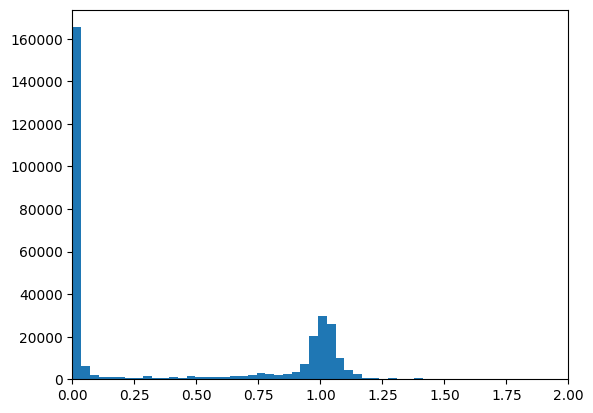

In [29]:
# view distribution of densities
dist = G_batched(Z_mean, mu, sigma, rho, lam=1e-3)
plt.hist(dist.flatten(),bins=10000)
plt.xlim([0,2])
plt.show()

In [30]:
path_embedded = pca.transform(geopath - np.mean(Z_mean))

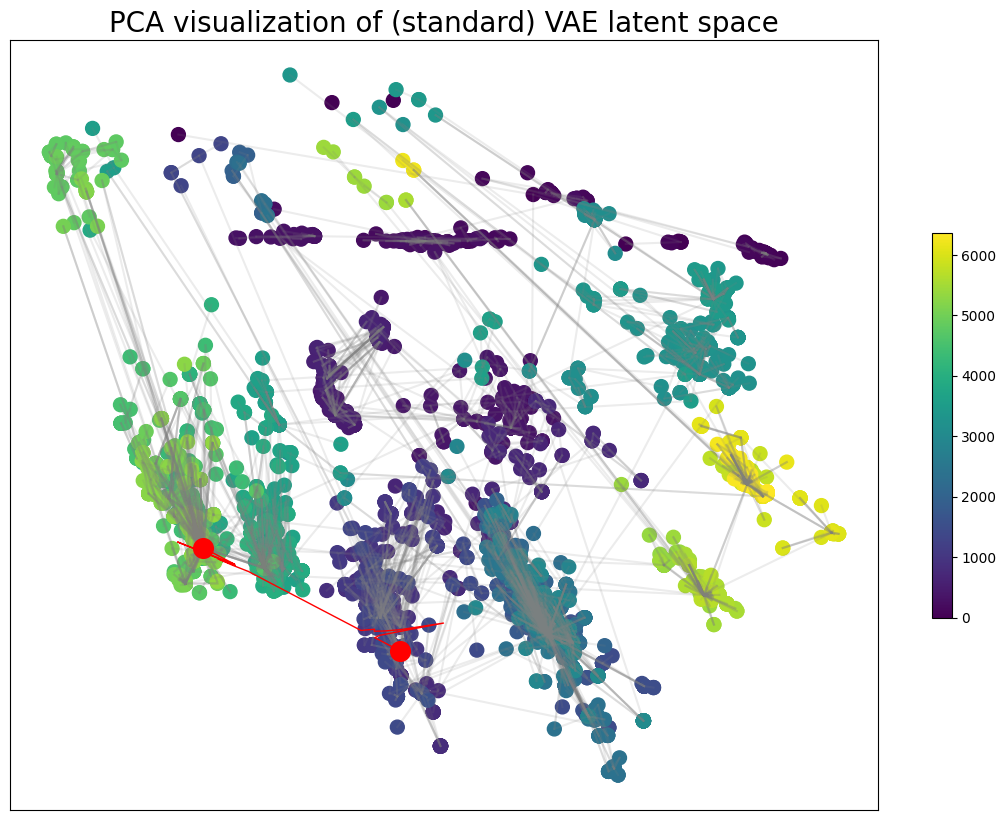

In [35]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]
    

# %matplotlib widget
# plt.ioff()
# fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
fig,ax = plt.subplots(1,1,figsize=(14,10))

# # RELATIONS
# for i,arr in enumerate(indexes):
#     # ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 0
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

# TIME 
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=collection_dates, cmap="viridis", s=150)
# scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=150)
scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], c=np.arange(Z_embedded.shape[0]), cmap="viridis", s=100)
fig.colorbar(scatterplot, ax=ax, shrink=0.5)

# GEODESIC
ax.scatter([path_embedded[x,0] for x in [0,-1]], [path_embedded[x,1] for x in [0,-1]], s=200, zorder=10, color="red")
ax.plot(path_embedded[:,0], path_embedded[:,1], linewidth=1, zorder=9, color="red")
# ax.scatter(path_embedded[[0,-1],0], path_embedded[[0,-1],1], path_embedded[[0,-1],2], s=200, color="red",zorder=10)
# ax.plot(path_embedded[:,0], path_embedded[:,1], path_embedded[:,2], linewidth=5, color="orange",zorder=10)


ax.set_title("PCA visualization of (standard) VAE latent space",fontsize=20)
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.15)
    # ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)

ax.set_xticks([])
ax.set_yticks([])
# ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()

## Euclid vs Hamming

In [ ]:
tot = 0
for N in range(new_dataset.shape[0]):
    X = torch.tensor(new_dataset[N:N+1])
    X = X.view(X.size(0), -1).to(DEVICE)
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = torch.exp(recon).detach().cpu().numpy()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = torch.nn.functional.softmax(recon.view(X.size(0), -1, len(ALPHABET)), dim=-1)
    # recon = recon.detach().cpu().numpy()
    # Z_mean = Z_mean.detach().cpu().numpy()

    X = X.view(X.size(0), -1, len(ALPHABET)).detach().cpu().numpy()
    X = np.argmax(X, axis=-1)
    recon = np.argmax(recon, axis=-1)
    tot += np.sum(np.not_equal(recon, X))

print("Average hamming dist between input sequence X and decoded sequence X'")
print(tot / new_dataset.shape[0])

In [ ]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
X = torch.tensor(new_dataset)
X_in = X.view(X.size(0), -1).to(DEVICE)

# STANDARD 
Z_mean, Z_logvar = vae_model.encoder.forward(X_in)
Z_mean = Z_mean.detach().cpu().numpy()

# BEDFORD
# recon, Z_mean, Z_logvar = vae_model.forward(X_in)
# recon = recon.detach().cpu().numpy()
# Z_mean = Z_mean.detach().cpu().numpy()

print(X.size(0))

genome = np.matmul(X.numpy(), np.array([1,2,3,4,5]))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = np.linalg.norm(Z_mean[i,:] - Z_mean[j,:])
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



In [ ]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("(standard) VAE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [ ]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])